In [1]:
import tensorflow as tf

In [2]:
import pathlib

In [3]:
data_dir = '/home/ifranco/tf_real_estate_images_classification/data/processed/REI-Dataset/'

In [4]:
data_dir = pathlib.Path(data_dir)

In [10]:
from __future__ import print_function

import tensorflow as tf
import os

# Dataset Parameters - CHANGE HERE
MODE = 'folder' # or 'file', if you choose a plain text file (see above).
DATASET_PATH = data_dir # the dataset file or root folder path.

# Image Parameters
N_CLASSES = 6 # CHANGE HERE, total number of classes
IMG_HEIGHT = 128 # CHANGE HERE, the image height to be resized to
IMG_WIDTH = 128 # CHANGE HERE, the image width to be resized to
CHANNELS = 3 # The 3 color channels, change to 1 if grayscale


# Reading the dataset
# 2 modes: 'file' or 'folder'
def read_images(dataset_path, mode, batch_size):
    imagepaths, labels = list(), list()
    if mode == 'file':
        # Read dataset file
        with open(dataset_path) as f:
            data = f.read().splitlines()
        for d in data:
            imagepaths.append(d.split(' ')[0])
            labels.append(int(d.split(' ')[1]))
    elif mode == 'folder':
        # An ID will be affected to each sub-folders by alphabetical order
        label = 0
        # List the directory
        try:  # Python 2
            classes = sorted(os.walk(dataset_path).next()[1])
        except Exception:  # Python 3
            classes = sorted(os.walk(dataset_path).__next__()[1])
        # List each sub-directory (the classes)
        for c in classes:
            c_dir = os.path.join(dataset_path, c)
            try:  # Python 2
                walk = os.walk(c_dir).next()
            except Exception:  # Python 3
                walk = os.walk(c_dir).__next__()
            # Add each image to the training set
            for sample in walk[2]:
                # Only keeps jpeg images
                if sample.endswith('.jpg') or sample.endswith('.jpeg'):
                    imagepaths.append(os.path.join(c_dir, sample))
                    labels.append(label)
            label += 1
    else:
        raise Exception("Unknown mode.")

    # Convert to Tensor
    imagepaths = tf.convert_to_tensor(imagepaths, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    # Build a TF Queue, shuffle data
    image, label = tf.train.slice_input_producer([imagepaths, labels],
                                                 shuffle=True)

    # Read images from disk
    image = tf.read_file(image)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)

    # Resize images to a common size
    image = tf.image.resize_images(image, [IMG_HEIGHT, IMG_WIDTH])

    # Normalize
    image = image * 1.0/127.5 - 1.0

    # Create batches
    X, Y = tf.train.batch([image, label], batch_size=batch_size,
                          capacity=batch_size * 8,
                          num_threads=4)

    return X, Y

In [11]:
# -----------------------------------------------
# THIS IS A CLASSIC CNN (see examples, section 3)
# -----------------------------------------------
# Note that a few elements have changed (usage of queues).

# Parameters
learning_rate = 0.001
num_steps = 10000
batch_size = 128
display_step = 1

# Network Parameters
dropout = 0.5 # Dropout, probability to keep units

# Build the data input
X, Y = read_images(DATASET_PATH, MODE, batch_size)


# Create model
def conv_net(x, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 64, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 32 filters and a kernel size of 5
        conv2 = tf.layers.conv2d(conv1, 128, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)
        # Because 'softmax_cross_entropy_with_logits' already apply softmax,
        # we only apply softmax to testing network
        out = tf.nn.softmax(out) if not is_training else out

    return out

W1130 14:16:11.533683 140135363417920 deprecation.py:323] From <ipython-input-10-f82c003f3b58>:58: slice_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W1130 14:16:11.539113 140135363417920 deprecation.py:323] From /home/ifranco/Documents/facultad/tesis/tesis_env/lib/python3.6/site-packages/tensorflow/python/training/input.py:374: range_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W1130 14:16:11.

In [ ]:
# Because Dropout have different behavior at training and prediction time, we
# need to create 2 distinct computation graphs that share the same weights.

# Create a graph for training
logits_train = conv_net(X, N_CLASSES, dropout, reuse=False, is_training=True)
# Create another graph for testing that reuse the same weights
logits_test = conv_net(X, N_CLASSES, dropout, reuse=True, is_training=False)

# Define loss and optimizer (with train logits, for dropout to take effect)
loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits_train, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.cast(Y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Saver object
saver = tf.train.Saver()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Start the data queue
    tf.train.start_queue_runners()

    # Training cycle
    for step in range(1, num_steps+1):

        if step % display_step == 0:
            # Run optimization and calculate batch loss and accuracy
            _, loss, acc = sess.run([train_op, loss_op, accuracy])
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
        else:
            # Only run the optimization op (backprop)
            sess.run(train_op)

    print("Optimization Finished!")

    # Save your model
    saver.save(sess, 'my_tf_model')

W1130 14:16:12.596974 140135363417920 deprecation.py:323] From <ipython-input-11-37431cb97aba>:25: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1130 14:16:12.606248 140135363417920 deprecation.py:506] From /home/ifranco/Documents/facultad/tesis/tesis_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1130 14:16:12.774926 140135363417920 deprecation.py:323] From <ipython-input-11-37431cb97aba>:27: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W1130 14:16:13.6030

In [ ]:
import numpy as np

In [8]:
data_dir = '/home/ifranco/tf_real_estate_images_classification/data/processed/REI-Dataset/train'

In [9]:
data_dir = pathlib.Path(data_dir)

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3403

In [11]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['livingRoom', 'bedroom', 'bathroom', 'frontyard', 'kitchen',
       'backyard'], dtype='<U10')

In [12]:
from IPython import display

from PIL import Image

from glob import glob

filenames = []
labels = []

train_dir = '/home/ifranco/tf_real_estate_images_classification/data/processed/REI-Dataset/train/'

for d in os.listdir(train_dir):
    category_filenames = glob(f'{train_dir}/{d}/*')
    filenames.extend(category_filenames)
    labels.extend([d for x in range(len(category_filenames))])

import numpy

mapping = {l: idx for idx, l in enumerate(np.unique(labels))}

category = [mapping[l] for l in labels]

len(category)

# step 1
filenames = tf.constant(filenames)
labels = tf.constant(category)

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# step 3: parse every image in the dataset using `map`
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)
dataset = dataset.batch(2)

# step 4: create iterator and final input tensor
iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
images, labels = iterator.get_next()


# step 3: parse every image in the dataset using `map`
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)
dataset = dataset.batch(2)

# step 4: create iterator and final input tensor
iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
images, labels = iterator.get_next()

In [37]:
[glob('/home/ifranco/tf_real_estate_images_classification/data/processed/REI-Dataset/train/*/')]

[['/home/ifranco/tf_real_estate_images_classification/data/processed/REI-Dataset/train/livingRoom/',
  '/home/ifranco/tf_real_estate_images_classification/data/processed/REI-Dataset/train/bedroom/',
  '/home/ifranco/tf_real_estate_images_classification/data/processed/REI-Dataset/train/bathroom/',
  '/home/ifranco/tf_real_estate_images_classification/data/processed/REI-Dataset/train/frontyard/',
  '/home/ifranco/tf_real_estate_images_classification/data/processed/REI-Dataset/train/kitchen/',
  '/home/ifranco/tf_real_estate_images_classification/data/processed/REI-Dataset/train/backyard/']]

In [ ]:
sess = tf.

In [110]:
images, labels

(<tf.Tensor 'IteratorGetNext_24340:0' shape=(?, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'IteratorGetNext_24340:1' shape=(?,) dtype=int32>)

In [108]:
sess.run([images, labels])

NameError: name 'sess' is not defined

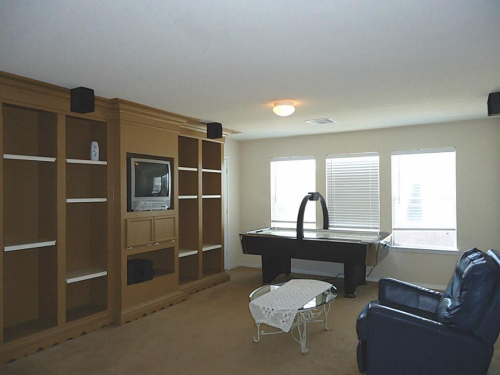

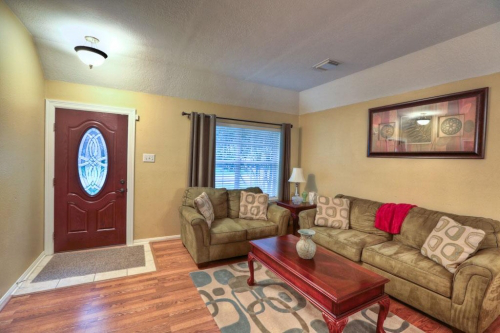

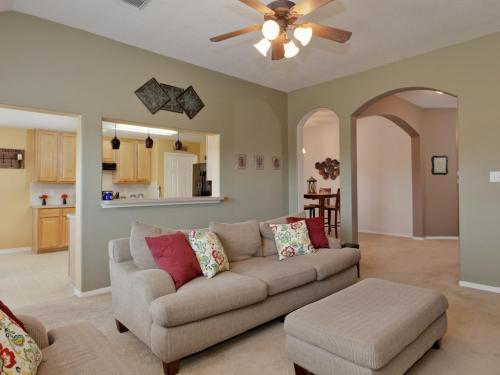

In [14]:
living = list(data_dir.glob('livingRoom/*'))

for image_path in living[:3]:
    display.display(Image.open(str(image_path)))

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/'))

In [29]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [30]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [31]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [32]:
import os

In [33]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path,)

AttributeError: 'Tensor' object has no attribute 'to_sparse'

In [34]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [35]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

NameError: name 'labeled_ds' is not defined